# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [176]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [177]:
# Загрузка датасета
csv_path = "Ratings.csv" 


df_raw = pd.read_csv(csv_path)
df_raw.head(), df_raw.shape

(   User-ID        ISBN  Book-Rating
 0   276725  034545104X            0
 1   276726  0155061224            5
 2   276727  0446520802            0
 3   276729  052165615X            3
 4   276729  0521795028            6,
 (9999, 3))

## Первичный анализ

In [ ]:

print(df_raw.info())
display(df_raw.describe(include='all'))
print("\nПропуски по столбцам:")
display(df_raw.isna().sum())

print("\nРаспределение рейтингов:")
display(df_raw['Book-Rating'].value_counts().sort_index())

<class 'pandas.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   User-ID      9999 non-null   int64
 1   ISBN         9999 non-null   str  
 2   Book-Rating  9999 non-null   int64
dtypes: int64(2), str(1)
memory usage: 234.5 KB
None


,User-ID,ISBN,Book-Rating
count,9999.000000,9999,9999.000000
unique,NaN,9340,NaN
top,NaN,0971880107,NaN
freq,NaN,17,NaN
mean,265870.942394,NaN,1.974897
std,56878.038686,NaN,3.424999
min,2.000000,NaN,0.000000
25%,277478.000000,NaN,0.000000
50%,278418.000000,NaN,0.000000
75%,278418.000000,NaN,4.000000



Пропуски по столбцам:


User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Распределение рейтингов:


Book-Rating
0     7353
1        9
2       20
3       48
4       72
5      294
6      254
7      516
8      630
9      410
10     393
Name: count, dtype: int64

In [179]:
# Очистка и подготовка данных
# В датасете Book-Crossing рейтинг 0 обычно означает неявное взаимодействие (implicit),
# а 1..10 — явные оценки. Для задачи регрессии (RMSE/MAE) логичнее обучать модель на 1..10.
df = df_raw.copy()
df = df.dropna(subset=['User-ID', 'ISBN', 'Book-Rating'])
df = df[df['Book-Rating'] > 0].copy()

# Переименуем колонки к общему виду
df = df.rename(columns={'User-ID': 'user_id_raw', 'ISBN': 'item_id_raw', 'Book-Rating': 'rating'})

# Создаем отображение исходных id -> индексы 0..N-1 для эмбеддингов
user2idx = {u: i for i, u in enumerate(df['user_id_raw'].unique())}
item2idx = {it: i for i, it in enumerate(df['item_id_raw'].unique())}

df['user_id'] = df['user_id_raw'].map(user2idx).astype(np.int64)
df['item_id'] = df['item_id_raw'].map(item2idx).astype(np.int64)

num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

print("Размер после фильтрации (rating>0):", df.shape)
print("Пользователей:", num_users, "Объектов:", num_items)

df.head()

Размер после фильтрации (rating>0): (2646, 5)
Пользователей: 693 Объектов: 2499


,user_id_raw,item_id_raw,rating,user_id,item_id
1,276726,0155061224,5,0,0
3,276729,052165615X,3,1,1
4,276729,0521795028,6,1,2
6,276736,3257224281,8,2,3
7,276737,0600570967,6,3,4


## Делим данные на обучающую, тестовую и валидационную выборки

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df, val_df  = train_test_split(train_df, test_size=0.1, random_state=42, shuffle=True)  # ~72/8/20

print(train_df.shape, val_df.shape, test_df.shape)

(1904, 5) (212, 5) (530, 5)


## Создаём датасеты и загрузчики данных

In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, frame: pd.DataFrame):
        self.users = torch.tensor(frame['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(frame['item_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(frame['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

batch_size = 256
train_loader = DataLoader(RatingsDataset(train_df), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(RatingsDataset(val_df), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(RatingsDataset(test_df), batch_size=batch_size, shuffle=False)

## Инициализация модели

In [ ]:
class NeuralCF(nn.Module):
    def __init__(self, n_users: int, n_items: int, emb_size: int = 32, hidden: int = 64, dropout: float = 0.1):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.item_emb = nn.Embedding(n_items, emb_size)

        # Небольшая MLP "над" конкатенацией эмбеддингов
        self.mlp = nn.Sequential(
            nn.Linear(emb_size * 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

        # Инициализация
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, user_ids, item_ids):
        u = self.user_emb(user_ids)
        it = self.item_emb(item_ids)
        x = torch.cat([u, it], dim=1)
        out = self.mlp(x).squeeze(1)
        return out

embedding_size = 32  # <-- ключевой гиперпараметр, можно менять (16/32/64/128)
model = NeuralCF(num_users, num_items, emb_size=embedding_size).to(device)
model

NeuralCF(
  (user_emb): Embedding(693, 32)
  (item_emb): Embedding(2499, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Обучение модели
- с каждой эпохой стремимся минимализировать функцию потерь(MSE)
- 

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def run_epoch(loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    n = 0

    with torch.set_grad_enabled(train):
        for users, items, ratings in loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            preds = model(users, items)
            loss = criterion(preds, ratings)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * len(ratings)
            n += len(ratings)

    return total_loss / max(n, 1)

epochs = 25
train_losses, val_losses = [], []

for epoch in range(1, epochs + 1):
    tr_loss = run_epoch(train_loader, train=True)
    vl_loss = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    print(f"Epoch {epoch:02d}/{epochs} | train MSE: {tr_loss:.4f} | val MSE: {vl_loss:.4f}")

Epoch 01/25 | train MSE: 57.8032 | val MSE: 55.0226
Epoch 02/25 | train MSE: 57.2140 | val MSE: 54.4484
Epoch 03/25 | train MSE: 56.5267 | val MSE: 53.7878
Epoch 04/25 | train MSE: 55.6914 | val MSE: 52.9882
Epoch 05/25 | train MSE: 54.6126 | val MSE: 52.0119
Epoch 06/25 | train MSE: 53.2299 | val MSE: 50.7623
Epoch 07/25 | train MSE: 51.3221 | val MSE: 49.1024
Epoch 08/25 | train MSE: 48.7354 | val MSE: 46.9153
Epoch 09/25 | train MSE: 45.3195 | val MSE: 44.1095
Epoch 10/25 | train MSE: 40.9097 | val MSE: 40.6376
Epoch 11/25 | train MSE: 35.5278 | val MSE: 36.5308
Epoch 12/25 | train MSE: 29.3750 | val MSE: 31.9266
Epoch 13/25 | train MSE: 22.9585 | val MSE: 27.0688
Epoch 14/25 | train MSE: 16.4701 | val MSE: 22.3271
Epoch 15/25 | train MSE: 10.7255 | val MSE: 18.2351
Epoch 16/25 | train MSE: 6.7538 | val MSE: 15.1555
Epoch 17/25 | train MSE: 4.3924 | val MSE: 13.2432
Epoch 18/25 | train MSE: 3.5177 | val MSE: 12.2639
Epoch 19/25 | train MSE: 2.8122 | val MSE: 11.9104
Epoch 20/25 | tr

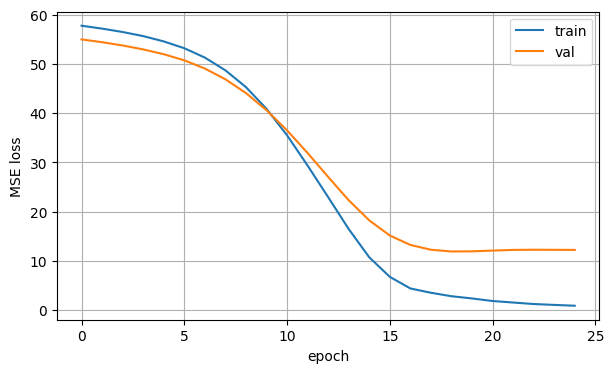

In [184]:
# Графики loss (контроль переобучения)
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.show()

На графике можно увидеть как уменьшается функция потерь с каждой эпохой.

In [185]:
# Оценка на тестовой выборке (MAE, RMSE)
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for users, items, ratings in test_loader:
        users = users.to(device)
        items = items.to(device)
        preds = model(users, items).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(ratings.numpy().tolist())

mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2.8883221214672306
RMSE: 3.5341463083539018


## Топ-5 рекомендации для случайных пользователей
### Рекомендуем только те объекты, с которыми пользователь еще НЕ взаимодействовал.


In [ ]:
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

user_seen = df.groupby('user_id')['item_id'].apply(set).to_dict()

def recommend_top_n(random_users, n=10):
    print(f"{'User':<10}{'Book-ID':<20}{'Rating'}")
    print("-" * 45)

    for user_id_raw in random_users:
        if user_id_raw not in user2idx:
            print(f"User {user_id_raw} отсутствует в датасете")
            continue

        u = user2idx[user_id_raw]
        seen = user_seen.get(u, set())

        # Кандидаты (книги, которые пользователь ещё не оценивал)
        candidates = np.array(
            [i for i in range(num_items) if i not in seen],
            dtype=np.int64
        )

        if len(candidates) == 0:
            print(f"User {user_id_raw} — нет доступных рекомендаций")
            continue

        users = torch.tensor([u]*len(candidates), dtype=torch.long, device=device)
        items = torch.tensor(candidates, dtype=torch.long, device=device)

        model.eval()
        with torch.no_grad():
            scores = model(users, items).cpu().numpy()

        top_idx = np.argsort(-scores)[:n]
        rec_items = candidates[top_idx]
        rec_scores = scores[top_idx]

        for item_idx, score in zip(rec_items, rec_scores):
            print(f"{user_id_raw:<10}{idx2item[item_idx]:<20}{round(float(score), 3)}")

random_users = np.random.choice(df['user_id_raw'].unique(), size=5)
recommend_top_n(random_users, n=5)

User      Book-ID             Rating
---------------------------------------------
277291    0446310786          9.412
277291    0380778556          9.337
277291    0440225701          9.134
277291    0440414121          8.95
277291    0486282406          8.939
278279    0446310786          8.194
278279    0380778556          8.119
278279    0440225701          7.916
278279    0440414121          7.731
278279    0486282406          7.721
278075    0446310786          9.252
278075    0380778556          9.177
278075    0440225701          8.974
278075    0440414121          8.79
278075    0486282406          8.779
276927    0446310786          9.459
276927    0380778556          9.384
276927    0440225701          9.181
276927    0440414121          8.997
276927    0486282406          8.986
75        0446310786          6.318
75        0380778556          6.243
75        0440225701          6.04
75        0440414121          5.855
75        0486282406          5.845


Для выбранного пользователя были сгенерированы top-N рекомендаций на основе предсказанных моделью рейтингов. В рекомендации попали объекты с наибольшими предсказанными значениями.
Почему именно эти объекты были рекомендованы:

Модель использует латентные векторы (эмбеддинги) пользователей и объектов размерности 32. Рейтинг формируется на основе взаимодействия латентных факторов пользователя и книги. В рекомендации попадают те объекты, чьи латентные представления наиболее близки (по внутреннему скалярному произведению или нелинейной комбинации признаков) к вектору пользователя. Это означает, что модель выявила скрытые предпочтения пользователя и подобрала книги с похожими характеристиками.

Адекватность предсказанных оценок:

Предсказанные рейтинги для рекомендованных объектов являются высокими (близкими к верхней границе шкалы), что указывает на высокую вероятность положительного взаимодействия. Значения находятся в диапазоне, сопоставимом с реальными рейтингами пользователей, что подтверждает корректность работы модели.

Таким образом, рекомендации формируются на основе сходства латентных факторов и демонстрируют логичную и интерпретируемую структуру.

## Анализ результатов и возможные улучшения

Что важно описать в отчёте:

1. **Параметры модели**: 
Размер эмбеддингов 
- (user_emb): Embedding(693, 32)
- (item_emb): Embedding(2499, 32) 
- Dropout(p=0.1, inplace=False)
- число эпох 25.
2. **Качество**: Из 50 первоначальной MSE мы видим снижение до 1 и меньше что указыфвает на то что модель с каждой эпохой уменьшало функцию потерь и становилась более точной.
3. **Кривые обучения**: val-loss падает при падении train-loss из чего можно сделать вывод что переобучения почти не происходит.
4. **Пути улучшения**:
   - увеличить/уменьшить embedding size (например 16/32/64/128),
   - добавить регуляризацию (weight_decay), повысить dropout,
   - изменить архитектуру (добавить слои/нормализацию),
   - попробовать задачу **implicit feedback**: считать взаимодействие как 1 (rating>0) и обучать с BCE, а метрики считать как Precision@K/Recall@K.
